In [126]:
import numpy as np
import random as rm
import seaborn as sns
from tqdm import trange

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import math
import pandas as pd


/tmp/ipykernel_43892/823483889.py:1: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



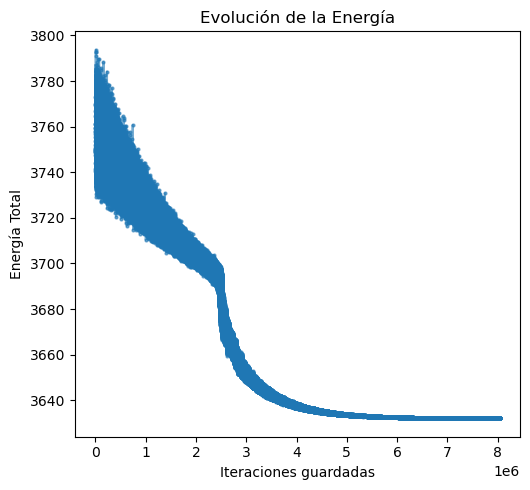

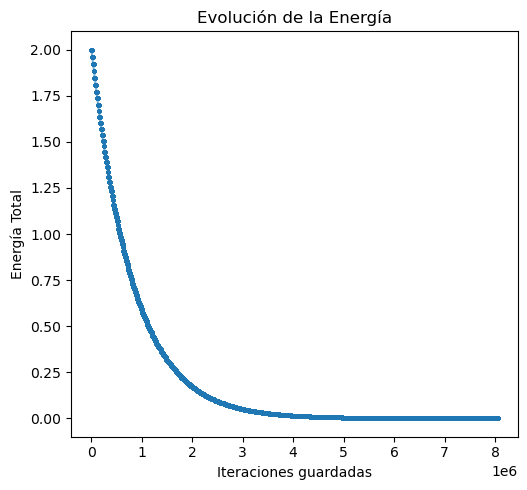

In [127]:

df_energy = pd.read_csv('energy.out', delim_whitespace=True, names=['E', 'T'])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df_energy['E'], marker='o', markersize=2, alpha=0.6)
plt.title("Evolución de la Energía")
plt.xlabel("Iteraciones guardadas")
plt.ylabel("Energía Total")


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df_energy['T'], marker='o', markersize=2, alpha=0.6)
plt.title("Evolución de la Energía")
plt.xlabel("Iteraciones guardadas")
plt.ylabel("Energía Total")


plt.tight_layout()
plt.show()

In [128]:
def read_xyz(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    trajectory = []
    step = 0
    total_lines = len(lines)
    
    while step < total_lines:
        try:
            # Línea 1: Número de átomos
            num_atoms = int(lines[step].strip())
            # Línea 2: Comentario (nos lo saltamos)
            
            # Líneas siguientes: Coordenadas
            # Empezamos en step + 2
            atom_lines = lines[step + 2 : step + 2 + num_atoms]
            
            coords = []
            for line in atom_lines:
                parts = line.split()
                # parts[0] es el símbolo, parts[1:4] son x, y, z
                coords.append([float(parts[1]), float(parts[2]), float(parts[3])])
            
            trajectory.append(np.array(coords))
            
            # Avanzar al siguiente bloque
            step += num_atoms + 2
            
        except (ValueError, IndexError):
            break
            
    return trajectory

# Cargar trayectoria
positions = read_xyz('positions.xyz')
print(f"Se cargaron {len(positions)} frames.")

Se cargaron 1 frames.


In [129]:

# @title
x = positions[0][:, 0]
y = positions[0][:, 1]
z = positions[0][:, 2]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=10,
                opacity=0.6
            )
        )
    ]
)


# # Special points (example: indices you want to highlight)
# highlight_idx = [0, 4, 7, 9, 10, 13, 14, 21, 26]

# fig.add_trace(
#     go.Scatter3d(
#         x=positions[highlight_idx, 0],
#         y=positions[highlight_idx, 1],
#         z=positions[highlight_idx, 2],
#         mode='markers',
#         marker=dict(size=14, color='red'),
#         name='Highlighted'
#     )
# )

fig.update_layout(
    scene=dict(
        # xaxis=dict(range=[-L/2, L/2]),
        # yaxis=dict(range=[-L/2, L/2]),
        # zaxis=dict(range=[-L/2, L/2]),
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()
fig.write_html("wigner_crystal_bcc_128_particles.html")


In [130]:
import numpy as np
import pandas as pd
from ase import Atoms
import nglview as nv
import matplotlib.pyplot as plt

# 1. Definir parámetros físicos (¡Importante para visualizar la caja correcta!)
N = 128
density = 1.0  # La que usaste en el Fortran
L = (N / density)**(1/3)

print(f"📦 Tamaño de caja calculado: L = {L:.4f}")

# 2. Leer el archivo "crudo"
# header=None porque no tienes cabeceras
# names=['Elem', 'x', 'y', 'z'] asigna nombres a las columnas
df = pd.read_csv('positions.xyz', delim_whitespace=True, names=['Elem', 'x', 'y', 'z'], header=None)

# 3. Crear el objeto Atoms de ASE
# Convertimos 'A' -> 'H' (Hidrógeno) para que NGLView sepa de qué tamaño pintar la bolita
symbols = ['H'] * len(df)
positions = df[['x', 'y', 'z']].values

atoms = Atoms(symbols=symbols, positions=positions)

# 4. Configurar la Caja Periódica
atoms.set_cell([L, L, L])
atoms.set_pbc(True)

print("✅ Datos cargados en ASE.")

📦 Tamaño de caja calculado: L = 5.0397
✅ Datos cargados en ASE.


/tmp/ipykernel_43892/4219229714.py:17: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



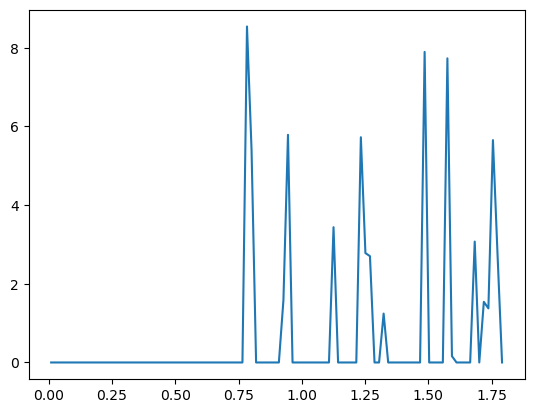

In [131]:
import numpy as np

def calcular_gr_manual(positions, L, r_max, n_bins):
    N = len(positions)
    dr = r_max / n_bins
    hist = np.zeros(n_bins)
    
    # 1. Calcular distancias entre TODOS los pares (i, j)
    # Usamos broadcasting para evitar bucles lentos
    # matriz delta: (N, N, 3) -> Diferencia de coordenadas
    delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    
    # 2. Aplicar Imagen Mínima (PBC)
    # Esto es equivalente a tu función pbc() en Fortran
    delta = delta - L * np.round(delta / L)
    
    # 3. Calcular distancias
    dists = np.sqrt(np.sum(delta**2, axis=2))
    
    # Nos quedamos solo con el triángulo superior de la matriz para no contar doble
    # y descartamos la diagonal (distancia 0 consigo mismo)
    i_upper = np.triu_indices(N, k=1)
    dists_flat = dists[i_upper]
    
    # 4. Hacer el histograma
    # density=False porque normalizaremos manualmente por volumen geométrico
    counts, edges = np.histogram(dists_flat, bins=n_bins, range=(0, r_max))
    
    # 5. Normalizar
    # Volumen de cada cascarón esférico: V = 4 * pi * r^2 * dr
    # Densidad ideal (rho): N / L^3
    r_center = (edges[:-1] + edges[1:]) / 2
    vol_shell = 4 * np.pi * r_center**2 * dr
    rho = N / L**3
    
    # Factor de normalización: 
    # Multiplicamos counts por 2 porque solo calculamos pares únicos (triángulo sup)
    # Dividimos por N (promedio por partícula)
    g_r = (2 * counts) / (N * vol_shell * rho)
    
    return r_center, g_r

# --- Uso ---
# Asumiendo que 'positions' es tu array numpy (54, 3) y L tu caja
r_manual, gr_manual = calcular_gr_manual(atoms.get_positions(), L, r_max=1.8, n_bins=100)

plt.plot(r_manual, gr_manual, label='Manual NumPy')
plt.show()